#1. Implement the MLP (own code) using the IRIS dataset and report the class-wise and overall accuracy for 5-fold cross validation



In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import math
from statistics import mean
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

In [ ]:
#loading the data
wine=datasets.load_wine()
print(wine.DESCR)
df=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])
X=pd.DataFrame(wine.data)
y=pd.DataFrame(wine.target)
print("ORIGINAL DATA:")
print(df)

#normalize the dataset
for column in X.columns:
    X[column] = (X[column] - X[column].min()) / (X[column].max() - X[column].min()) 


df=X.copy()
df['target']=y

#DATA PREPROCESSING- ONE HOT ENCODING
y = pd.get_dummies(df.target, prefix='target')
y = LabelBinarizer().fit_transform(df.target)
X=X.to_numpy()
X, y = shuffle(X, y)

print("After one hot encoding: \n",X,y)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

In [ ]:
def MLP(X,y,learning_rate,epochs):
  
  X = np.insert(X, 0 , 1 , axis=1)
  l=learning_rate
  #weights for hidden layer
  W_hidden=[]
  for i in range(X.shape[1]):
    w=[]
    for j in range(X.shape[1]):
       w.append(0.1)
    W_hidden.append(w)   
 
  W_hidden= np.array(W_hidden)  
  
  #weights for output layer
  W_output=[]
  for i in range(3):
    w=[]
    for j in range(X.shape[1]+1):
       w.append(0.1)
    W_output.append(w)   
 
  W_output= np.array(W_output)  
  visited_index=[]
  index = random.randint(0, len(X)-1)
  epoch=1
  converged=True
  err_in=0
  err=0
  while converged:

    #input to hidden
    h=1/(1+np.exp(-np.dot(W_hidden,np.transpose(X[index]))))
    
    h1 = np.insert(h, 0 , 1)
    #hidden to output
    d=1/(1+np.exp(-np.dot(W_output,np.transpose(h1))))
    
    err_in= err_in+(1/2)*sum((d-y[index])**2)
    
    #local gradient error in output neuron
    grad_err_output=[]
    for i in range(len(d)):
      grad_err_output.append(d[i]*(1-d[i])*(y[index][i]-d[i]))


    #local gradient error in hidden neuron
    grad_err_hidden=[]
    for i in range(len(h)):
      grad_err_hidden.append(float(W_output[0][i]*grad_err_output[0] + W_output[1][i]*grad_err_output[1] + W_output[2][i]*grad_err_output[2])* (float)(h[i]) * (float)(1 - h[i]))

     #update weights between hidden and output
    for i in range(W_output.shape[0]):
        for j in range(W_output.shape[1]):
          W_output[i][j]=W_output[i][j]+(l*grad_err_output[i]*h1[j])  

    #update weights between input and hidden
    for i in range(W_hidden.shape[0]):
        for j in range(W_hidden.shape[1]):
          W_hidden[i][j]=W_hidden[i][j]+(l*grad_err_hidden[i]*X[index][j])      
    
    index = random.randint(0, len(X)-1)
    visited_index.append(index)
    
    if (len(set(visited_index))==len(X)):
      epoch=epoch+1
      d=1/(1+np.exp(-np.dot(W_output,np.transpose(h1))))
      err= err+(1/2)*sum((d-y[index])**2)
    
      if(abs(err-err_in)<0.001 or epoch==epochs):
        print("Successfully converged")
        print("No of epochs: ",epoch)
        converged=False
      else:
        visited_index=[]
        err_in=0
        err=0  

  return W_hidden , W_output , err

In [ ]:
def predict(X, y ,w1, w2):
  
  X = np.insert(X, 0 , 1 , axis=1)
  Y_predict=np.zeros(len(y))
  Y=np.zeros(len(y))
  h=[]
  d=[]
  for i in range(len(y)):
     d1= 1/(1+np.exp(-(np.dot(w1,np.transpose(X[i])))))
     h.append(d1)

  for i in range(len(h)):
     h1 = np.insert(h[i], 0 , 1)
     d1= 1/(1+np.exp(-(np.dot(w2,np.transpose(h1)))))
     d.append(d1)   
 
  for i in range(len(d)):
     max_index= np.argmax(d[i], axis=0)
     Y_predict[i]=max_index

  for i in range(len(y)):
    max_index= np.argmax(y[i], axis=0)
    Y[i]=max_index    

  test_acc=accuracy_score(Y,Y_predict)  
  
  return test_acc,Y,Y_predict

In [ ]:
#splitting the dataset

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.6)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

#Training the model
w=MLP(X_train,y_train,0.2,70)
print("Accuracy for the test set: ",predict(X_test,y_test,w[0],w[1])[0]*100)

Successfully converged
No of epochs:  70
Accuracy for the test set:  100.0


In [ ]:
k = 5
kf = KFold(n_splits=k, random_state=None) 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X[train_index,:],X[test_index,:]
    y_train , y_test = y[train_index,:] , y[test_index,:]
     
    w=MLP(X_train,y_train,0.2,70)
     
    acc = predict(X_test , y_test,w[0],w[1])
    acc_score.append(acc[0]*100)
    confusion(acc[1],acc[2])
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))


Successfully converged
No of epochs:  70
Class-wise Accuracy:  [1. 1. 1.]
Class-wise Precision:  [1. 1. 1.]
Class-wise Recall:  [1. 1. 1.]
Successfully converged
No of epochs:  70
Class-wise Accuracy:  [0.91666667 1.         0.90909091]
Class-wise Precision:  [1.         0.86666667 1.        ]
Class-wise Recall:  [0.91666667 1.         0.90909091]
Successfully converged
No of epochs:  70
Class-wise Accuracy:  [1.         0.85714286 1.        ]
Class-wise Precision:  [0.94117647 1.         1.        ]
Class-wise Recall:  [1.         0.85714286 1.        ]
Successfully converged
No of epochs:  70
Class-wise Accuracy:  [1.         0.94117647 1.        ]
Class-wise Precision:  [1.  1.  0.9]
Class-wise Recall:  [1.         0.94117647 1.        ]
Successfully converged
No of epochs:  70
Class-wise Accuracy:  [1. 1. 1.]
Class-wise Precision:  [1. 1. 1.]
Class-wise Recall:  [1. 1. 1.]
accuracy of each fold - [100.0, 94.44444444444444, 97.22222222222221, 97.14285714285714, 100.0]
Avg accuracy :

In [ ]:
def confusion(Y,Y_predict):

  cm = confusion_matrix(Y, Y_predict) 
  p=precision_score(Y, Y_predict, average=None, zero_division=1)
  r=recall_score(Y, Y_predict, average=None, zero_division=1)
  
  #Now the normalize the diagonal entries

  cm = cm.astype('float') / cm.sum(axis=1) 
  print("Class-wise Accuracy: ",cm.diagonal())
  print("Class-wise Precision: ",p)
  print("Class-wise Recall: ",r)

# 2. Implement the K-means (own code) clustering algorithm on the IRIS dataset(without using the label). Report the sum-square-error (SSE) by varying K value




In [ ]:
#importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets

In [ ]:
#loading the iris dataset
iris = datasets.load_iris()      
df = pd.DataFrame(iris.data)
df.columns = iris.feature_names
df['target'] = iris.target
print(df)
print(df.head())
print(df.tail())

     sepal length (cm)  sepal width (cm)  ...  petal width (cm)  target
0                  5.1               3.5  ...               0.2       0
1                  4.9               3.0  ...               0.2       0
2                  4.7               3.2  ...               0.2       0
3                  4.6               3.1  ...               0.2       0
4                  5.0               3.6  ...               0.2       0
..                 ...               ...  ...               ...     ...
145                6.7               3.0  ...               2.3       2
146                6.3               2.5  ...               1.9       2
147                6.5               3.0  ...               2.0       2
148                6.2               3.4  ...               2.3       2
149                5.9               3.0  ...               1.8       2

[150 rows x 5 columns]
   sepal length (cm)  sepal width (cm)  ...  petal width (cm)  target
0                5.1               3.5  ..

In [ ]:
#removed label column 
X = df.iloc[:,0:4].to_numpy()
Y = df.iloc[:,-1].to_numpy() 
print(X)
print(Y)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

In [ ]:
#computes euclidean distance between x and y
def euclidianDist( x, y):
  return np.sqrt(np.sum(np.power((x - y), 2)))

In [ ]:
# X: dataset without label column and it contains 4 features and 150 patterns
# k: number of clusters
# mx_itr : maximum no of iterations/ convergence criteria of kMeans  

def kMeans(X,k,mx_itr=300):
  centers = {}

  #step 1: randomly choose k objects from dataset X as intial cluster centers
  for i in range(k):
    centers[i] = X[i]
  
  #step 4:check for convergence
  for i in range(mx_itr):
    curr_classification = {}   # stores the k clusters
    distance = []       # stores distance between curr obj and k cluster centers
    
    for j in range(k):
      curr_classification[j] = []  

    #step 2: for each objects in X do some operations:
    for row in X:

      #1: compute distance between curr obj and k cluster centers
      distance = [euclidianDist(row,centers[center]) for center in centers]

      #2: assign the object to that cluster to which it is closest by finding the index of minimum distance cluster center
      curr_class = distance.index(min(distance))
      curr_classification[curr_class].append(row)

    #step 3: update the cluster centers by taking the average of the patterns that belong to that cluster
    for j in range(k):  
      centers[j] = np.average(curr_classification[j],axis=0)  
    
  return centers

In [ ]:
#classify each object to its closest cluster
# predicts cluster of each objects : means objects belong to which cluster
def predict(X,centers):
  cls =[]
  for row in X:
    distance = [euclidianDist(row,centers[center]) for center in centers]
    curr_class = distance.index(min(distance))
    cls.append(curr_class)
  return np.array(cls)

In [ ]:
# calculates SSE
# x: dataset X
# y: cluster no of each objects /objects belong to which cluster
# center: centers of k clusters
def distortion(x,y,center):
  unique = np.unique(y)
  classes = []
  for i in range(len(unique)):
    cls = x[y == unique[i]]
    classes.append(cls)
  
  dist = 0
  for i in range(len(unique)):
    for j in range(len(classes[i])):
      dist += (euclidianDist(classes[i][j],center[i])**2)
             
  return dist

In [ ]:
squaredSum =[]  ## stores SSE of different k
selfCenters = [] ## stores cluster centers of different k

for k in range(1,10):
    
    center = kMeans(X,k)  #finding k cluster centers after k-means operation
    predClass = predict(X,center)  #classify each object to its closest cluster
    
    sqSum = distortion(X,predClass,center) #calcullates SSE
    squaredSum.append(sqSum)                                 
    selfCenters.append(center)

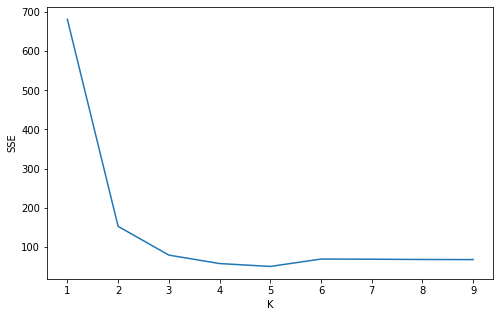

In [ ]:
#sum-square-error (SSE) by varying K(cluster count) value
plt.figure(figsize=(8,5))
plt.plot(range(1, 10), squaredSum)
plt.ylabel('SSE')
plt.xlabel('K')
plt.show()

# 3. Implement the MLP and k-means on the IRIS dataset using the inbuilt library function. Compare the results with the above-mentioned two questions.


### Implement MLP Using Inbuilt library function

In [ ]:
#using inbuilt function
from sklearn.neural_network import MLPClassifier
#loading the data
wine=datasets.load_wine()
df=pd.DataFrame(data=np.c_[wine['data'],wine['target']],columns=wine['feature_names']+['target'])
X_1=pd.DataFrame(wine.data)
y_1=pd.DataFrame(wine.target)

#normalize the dataset
for column in X_1.columns:
    X_1[column] = (X_1[column] - X_1[column].min()) / (X_1[column].max() - X_1[column].min()) 

X_1=X_1.to_numpy()
y_1=y_1.to_numpy()
#splitting the dataset

# In the first step we will split the data in training and remaining dataset
X_train_1, X_rem, y_train_1, y_rem = train_test_split(X_1,y_1, train_size=0.6)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_rem,y_rem, test_size=0.5)
clf = MLPClassifier(random_state=1, max_iter=700).fit(X_train_1, y_train_1.ravel())

print("Accuracy: ",clf.score(X_test_1, y_test_1)*100)

Accuracy:  91.66666666666666


In [ ]:
k = 5
kf = KFold(n_splits=k, random_state=None,shuffle=True) 
acc_score = []
i=1
for train_index , test_index in kf.split(X_1):
    X_train_1 , X_test_1 = X_1[train_index],X_1[test_index]
    y_train_1 , y_test_1 = y_1[train_index] , y_1[test_index]
     
    clf = MLPClassifier(random_state=1, max_iter=700).fit(X_train_1, y_train_1.ravel())
    y_pred=clf.predict(X_test_1)
    acc_score.append(clf.score(X_test_1, y_test_1)*100)
    print("For ",i," fold: \n")
    confusion(y_test_1,y_pred)
    i=i+1 
avg_acc_score = sum(acc_score)/k

print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

For  1  fold: 

Class-wise Accuracy:  [1.         0.93333333 1.        ]
Class-wise Precision:  [1.         1.         0.90909091]
Class-wise Recall:  [1.         0.93333333 1.        ]
For  2  fold: 

Class-wise Accuracy:  [1. 1. 1.]
Class-wise Precision:  [1. 1. 1.]
Class-wise Recall:  [1. 1. 1.]
For  3  fold: 

Class-wise Accuracy:  [0.92857143 0.92857143 1.        ]
Class-wise Precision:  [1.         0.92857143 0.88888889]
Class-wise Recall:  [0.92857143 0.92857143 1.        ]
For  4  fold: 

Class-wise Accuracy:  [1.    1.    0.875]
Class-wise Precision:  [1.     0.9375 1.    ]
Class-wise Recall:  [1.    1.    0.875]
For  5  fold: 

Class-wise Accuracy:  [1. 1. 1.]
Class-wise Precision:  [1. 1. 1.]
Class-wise Recall:  [1. 1. 1.]
accuracy of each fold - [97.22222222222221, 100.0, 94.44444444444444, 97.14285714285714, 100.0]
Avg accuracy : 97.76190476190477


### Implement K-means Using Inbuilt library functions

In [ ]:
from sklearn.cluster import KMeans
ssSklrn =[] #stores sse of different k
centers = [] #stores centers of different k

for k in range(1,10):   
    km = KMeans(n_clusters=k)
    km.fit(X)  #applying k-means
    ssSklrn.append(km.inertia_)      #storing SSE                           
    centers.append(km.cluster_centers_)  #storing centers

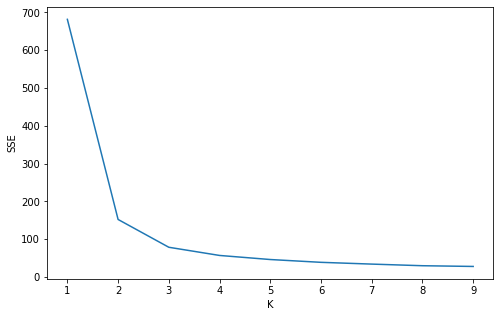

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, 10), ssSklrn)
plt.ylabel('SSE')
plt.xlabel('K')
plt.show()

### compare Results

# 4. Implement the PSO and genetic algorithm (GA) for clustering considering any one feature of the IRIS dataset and report SSE.


### Implementation of GA

### Implementation of PSO